# Team Update 6

For this assignment, you'll be looking at the current state of your design process and evaluating the effect of potential changes to your design.

In [1]:
import os
from pathlib import Path

import sys
ISST_DIR = str(Path(os.getcwd()).parent.parent.parent)
sys.path.append(ISST_DIR)

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd

import matplotlib.pyplot as plt

import ISST

# Evaluating Utility

In Team Update 5, you implemented your Impact Tables, and looked at the effects of individual risks on the parameters that those Impact Tables quantified. Now we'll start to work on actually using the results of the analysis for decision making in our design process. To do this, we'll need to revisit utility functions.

In Team Update 5, you plotted the discrete and logistic utility functions defined by your Impact Tables, but you also have the option of defining your own utility functions.

For instance, if your impact parameters is some "error" from a nominal value, e.g. you're targeting a particular orbital altitude, you could define an Impact table that defines the utility function in terms the deviation from the nominal value: 

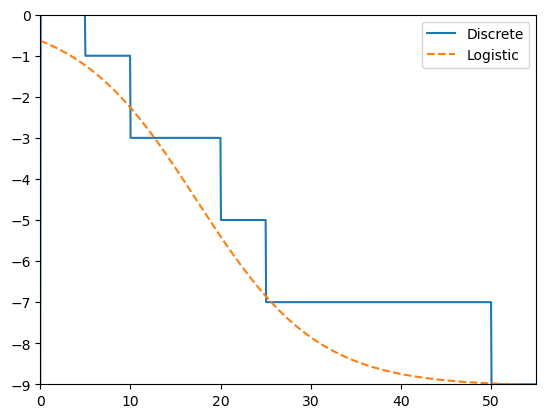

In [2]:
Altitude_Impact_Table = ISST.RiskTable(name='Orbital Altitude Error',
                                         units='km',
                                         utility_breakpoints=[0, 5., 10., 20., 25., 50.],
                                         utilities=[0., -1., -3., -5., -7., -9.],
                                         utility_names=['0 km Error',
                                                        '5 km Error',
                                                        '10 km Error',
                                                        '20 km Error',
                                                        '25 km Error',
                                                        '50 km Error']
)

Altitude_Impact_Table.plot_utilities()

Let's set up a basic design system incorporating this as a technical parameter, using the same cost and schedule tables as in the Example System Setup notebook, and with a risk of navigation system error. Since we're using just the one risk, we'll set its parameters manually instead of reading them in from a file:

In [3]:
Nav_Risk = ISST.Risk(name='Navigation Risk',
                     baseline_likelihood = 0.9,
                     
                     #Schedule Risk Parameters
                     schedule_risk_minimum_value=1.,
                     schedule_risk_maximum_value=18.,
                     schedule_risk_most_likely_value=3., 
                                                      
                     # Cost Risk Parameterers         
                     cost_risk_minimum_value=np.log10(100000),
                     cost_risk_maximum_value=np.log10(2000000), 
                     cost_risk_most_likely_value=np.log10(500000),
                                                      
                     # Technical Risk Parameters      
                     technical_risk_minimum_values=[-50.],
                     technical_risk_maximum_values=[200.],
                     technical_risk_most_likely_values=[0.]
                     )

Log_Cost_Risk_Table = ISST.RiskTable(name='LogCost',
                                       units='logEUR',
                                       utility_breakpoints=[5., 6., 6.69897, 7., 7.69897, 8.],
                                       utilities=[-1., -2., -4., -6., -8., -10.],
                                       utility_names=['100k Euros',
                                                      '1M Euros',
                                                      '5M Euros',
                                                      '10M Euros',
                                                      '50M Euros',
                                                      '100M Euros'])

Schedule_Risk_Table = ISST.RiskTable(name='Schedule',
                                       units='months',
                                       utility_breakpoints=[0., 3., 6., 12., 24., 36., 60., 120.],
                                       utilities=[0., -0.5, -1., -2., -3., -5., -7., -10.],
                                       utility_names=['0 months',
                                                      '3 months',
                                                      '6 months',
                                                      '12 months',
                                                      '24 months',
                                                      '36 months',
                                                      '60 months',
                                                      '120 months'])

Example_Design_System = ISST.DesignSystem(name='Example_Design_System',
                                          model_context=pm.Model(),
                                          risks=[Nav_Risk],
                                          schedule_risk_table = Schedule_Risk_Table,
                                          cost_risk_table = Log_Cost_Risk_Table,
                                          technical_risk_tables = [Altitude_Impact_Table])

#results = Example_Design_System.analyze_system()
results = az.from_netcdf('Analysis_Results_TU6.nc')

Now that we have our results, let's look at the impact on altitude specifically:

In [4]:
az.summary(results,
           var_names=['Total Orbital Altitude'],
           filter_vars='like',
           round_to=2,
           kind='stats')

,mean,sd,hdi_3%,hdi_97%
Total Orbital Altitude Error Impact,22.3,39.02,-41.61,91.34


<AxesSubplot: title={'center': 'Total Orbital Altitude Error Impact'}>

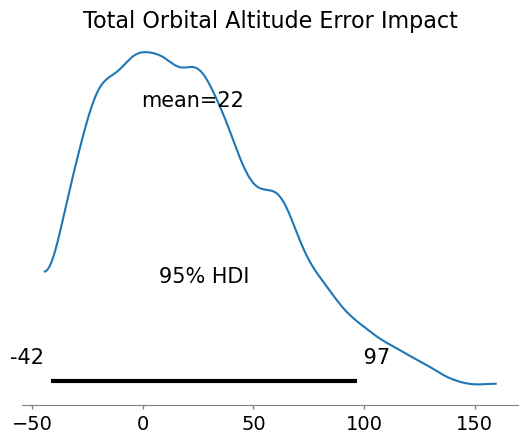

In [5]:
az.plot_posterior(results,
                  var_names=['Total Orbital Altitude'],
                  filter_vars='like',
                  hdi_prob=0.95)

This works well enough, but note that in this example, the direction of the error really affects the actual utility impact of the error, and our utility breakpoints are all positive, based on the absolute value of the error. If we check the utility of the absolute values of our mean and 95% confidence limits, we get: 

In [6]:
mean = np.asarray(results.posterior.mean()['Total Orbital Altitude Error Impact'])
confidence_bounds = np.asarray(az.hdi(results, hdi_prob=0.95)['Total Orbital Altitude Error Impact'])

print(f'Utility for Average Impact ({mean: .2f} km): {Altitude_Impact_Table.logistic_utility(mean): .2f}')

print(f'Utility for Lower Confidence Bound ({confidence_bounds[0]: .2f} km): {Altitude_Impact_Table.logistic_utility(np.abs(confidence_bounds)[0]): .2f}')

print(f'Utility for Upper Confidence Bound ({confidence_bounds[1]: .2f} km): {Altitude_Impact_Table.logistic_utility(np.abs(confidence_bounds)[1]): .2f}')

Utility for Average Impact ( 22.30 km): -6.12
Utility for Lower Confidence Bound (-41.61 km): -8.81
Utility for Upper Confidence Bound ( 97.00 km): -9.05


On average, we expect to be 22.77 km off from our nominal orbit altitude and lose -6.25 points of utility due to navigation errors, and more at the extremes of our confidence intervals, but note that the impact of the errors is symmetric whether they're positive or negative. Is that actually what we want?

The Lunar Reconnaissance Orbiter has an orbital perigee (technically periselene for the moon) of 20 km, so being 20 km *below* your nominal altitude is a much worse outcome than being 20 km *above* your nominal altitude. Our utility function probably looks more like an assymetric bell curve, which goes to -10 much faster on the negative side of the curve than it does on the positive side of the curve:

In [7]:
def bell_curve_utility(impact, max_utility=10, center=0., decay_rate = 1.):
    return -max_utility * (1 - np.exp(-(impact-center)**2/(1/decay_rate)))

def orbital_error_utility(altitude_error):
    return ((altitude_error < 0) * bell_curve_utility(altitude_error, decay_rate = 0.01) +
            (altitude_error >= 0) * bell_curve_utility(altitude_error, decay_rate = 0.0001))

In the above cell, `(altitude_error < 0)` returns `True (==1)` if our error is negative, and `False (==0)` otherwise, vice-versa for `(altitude_error >= 0)`. This way, only the version of bell_curve_utility that has the decay_rate appropriate to that side of the curve is used without having to use an if statement. Let's plot it over a range of potential errors to see what it looks like:

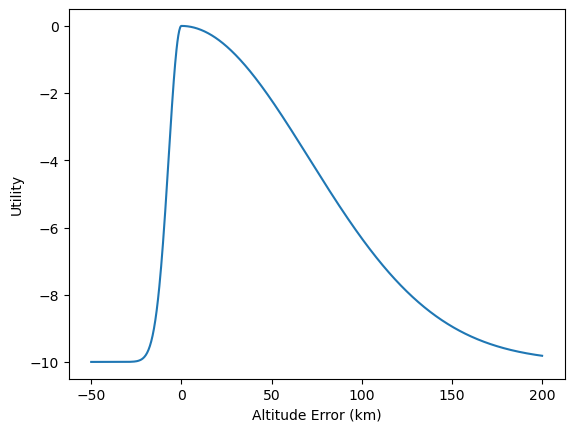

In [8]:
error_range = np.linspace(-50., 200., 1000)
plt.plot(error_range, orbital_error_utility(error_range))
plt.xlabel('Altitude Error (km)')
plt.ylabel('Utility')
plt.show()

Let's instead calculate the utility for our mean and 95% confidence limits using this utility function, this time dropping the absolute value conversion:

In [9]:
print(f'Utility for Average Impact ({mean: .2f} km): {orbital_error_utility(mean): .2f}')

print(f'Utility for Lower Confidence Bound ({confidence_bounds[0]: .2f} km): {orbital_error_utility(confidence_bounds[0]): .2f}')

print(f'Utility for Upper Confidence Bound ({confidence_bounds[1]: .2f} km): {orbital_error_utility(confidence_bounds[1]): .2f}')

Utility for Average Impact ( 22.30 km): -0.49
Utility for Lower Confidence Bound (-41.61 km): -10.00
Utility for Upper Confidence Bound ( 97.00 km): -6.10


Now, our utilities match our understanding of the system better - being 22.77 km above our nominal altitude isn't too bad, but being more than 90 km above is a real problem, however being more than 40 km *below* our nominal altitude is a total loss.

# Reviewing Previous Results

First, let's look at your results from Team Update 5 in terms of utility functions. By default, Team Update 5 saved your results as `Analysis Results.nc`. If you have changed the name of the results file, you'll need to change the name of the file in the next cell:

In [10]:
TU5_Results = az.from_netcdf('TU5_Analysis_Results.nc')

First, let's look at the cost and schedule utilities. You can either reconstruct the Impact Tables you used in Team Update 5 by copy and pasting below: 

In [11]:
Cost_Risk_Table = ISST.RiskTable(name='Cost',
                                 units = 'euros',
                                 utility_breakpoints=([-25, 0, 25, 50, 75, 100, 125, 150]),
                                 utilities=[-0.4, -1., -2., -3.8, -5.8, -7.6, -8.6, -9.2],
                                 utility_names=['-25M Euros',
                                                '0M Euros',
                                                '25M Euros',
                                                '50M Euros',
                                                '75M Euros',
                                                '100M Euros',
                                                '125M Euros',
                                                '150M Euros']
                                 )

Schedule_Risk_Table = ISST.RiskTable(name='Schedule',
                                     units = 'months',
                                     utility_breakpoints=[-3., 0, 3., 6., 9., 12., 16., 20.],
                                     utilities=[0., -1., -2., -5., -7, -8., -9., -10.],
                                     utility_names=['-3 Months',
                                                '0 Months',
                                                '3 Month',
                                                '6 Months',
                                                '9 Months',
                                                '12 Months',
                                                '16 Months',
                                                '20 Months']
                                     )

OR by definining custom utility functions here:

In [12]:
#def custom_cost_utility_function(impact):   
#    return 
#def custom_schedule_utility_function(impact):
#    return

Run ONE the following cells to create an alias to your chosen utility method for cost:

And run ONE of the following cells to create an alias for your chosen utility method for schedule:

In [13]:
# Run this cell to use the Impact Table's logistic utility function
cost_utility_function = Cost_Risk_Table.logistic_utility

# Run this cell to use the Impact Table's logistic utility function
schedule_utility_function = Schedule_Risk_Table.logistic_utility

In [14]:
# Run this cell to use the Impact Table's discrete utility function
#cost_utility_function = Cost_Risk_Table.discrete_utility

# Run this cell to use the Impact Table's discrete utility function
#schedule_utility_function = Schedule_Risk_Table.discrete_utility

# Run this cell to use your custom utility function
#cost_utility_function = custom_cost_utility_function

# Run this cell to use your custom utility function
#schedule_utility_function = custom_schedule_utility_function

Now, let's look at the utility for your mean and 95% confidence limits on cost and schedule:

In [15]:
cost_mean = np.asarray(TU5_Results.posterior.mean()['Total Cost Impact'])
schedule_mean = np.asarray(TU5_Results.posterior.mean()['Total Schedule Impact'])

cost_confidence_bounds = np.asarray(az.hdi(TU5_Results, hdi_prob=0.95)['Total Cost Impact'])
schedule_confidence_bounds = np.asarray(az.hdi(TU5_Results, hdi_prob=0.95)['Total Schedule Impact'])

In [16]:
print(f'Utility for Expected Cost Impact: {cost_utility_function(cost_mean): .2f}')

print(f'Utility for Lower Confidence Bound: {cost_utility_function(cost_confidence_bounds[0]): .2f}')

print(f'Utility for Upper Confidence Bound: {cost_utility_function(cost_confidence_bounds[1]): .2f}')

Utility for Expected Cost Impact: -2.94
Utility for Lower Confidence Bound: -1.74
Utility for Upper Confidence Bound: -4.31


In [17]:
print(f'Utility for Expected Schedule Impact: {schedule_utility_function(schedule_mean): .2f}')

print(f'Utility for Lower Confidence Bound: {schedule_utility_function(schedule_confidence_bounds[0]): .2f}')

print(f'Utility for Upper Confidence Bound: {schedule_utility_function(schedule_confidence_bounds[1]): .2f}')

Utility for Expected Schedule Impact: -8.72
Utility for Lower Confidence Bound: -4.30
Utility for Upper Confidence Bound: -9.51


Repeat this process for each of your technical impacts, copying and pasting the following cells if you have more than three technical parameters (Make sure the name of the parameter matches Team Update 5):

Technical Parameters:

In [18]:
nominal_power = 800
nominal_mass = 1000
nominal_dv = 500
nominal_GRS = 30

In [19]:
Payload_Power = ISST.RiskTable(name='Power',
                                 units = 'W',
                                 utility_breakpoints=np.array([0., 750., 800.])-nominal_power,
                                 utilities=[0., 5., 10.],
                                 utility_names=['Under Spec', 'Near Spec', 'At Spec']
                                 )

Payload_Power.L = 10
Payload_Power.k = 0.5
Payload_Power.x0 = 800-nominal_power

In [20]:
# Run this cell to use the Impact Table's logistic utility function
Payload_Power_utility_function = Payload_Power.logistic_utility

In [21]:
# Run this cell to use the Impact Table's discrete utility function
#T1_utility_function = T1_Risk_Table.discrete_utility

In [22]:
# Run this cell to use your custom utility function
#def custom_T1_utility_function(impact):
    
#    return

#T1_utility_function = custom_T1_utility_function

In [23]:
Payload_Power_mean = np.asarray(TU5_Results.posterior.mean()[f'Total {Payload_Power.name} Impact'])
Payload_Power_confidence_bounds = np.asarray(az.hdi(TU5_Results, hdi_prob=0.95)[f'Total {Payload_Power.name} Impact'])

print(f'Utility for Expected {Payload_Power.name} Impact: {Payload_Power_utility_function(Payload_Power_mean): .2f}')

print(f'Utility for Lower Confidence Bound: {Payload_Power_utility_function(Payload_Power_confidence_bounds[0]): .2f}')

print(f'Utility for Upper Confidence Bound: {Payload_Power_utility_function(Payload_Power_confidence_bounds[1]): .2f}')

Utility for Expected Power Impact:  3.68
Utility for Lower Confidence Bound:  1.93
Utility for Upper Confidence Bound:  5.19


Technical Parameter 2:

In [24]:
Payload_Mass = ISST.RiskTable(name='Mass',
                                 units = 'kg',
                                 utility_breakpoints=np.array([800., 1000., 1200., 1500., 2000.])-nominal_mass,
                                 utilities=[10., 8., 5., 2., 0.],
                                 utility_names=['200 kg Below Spec',
                                                'At Spec',
                                                '200 kg Above Spec',
                                                '500 kg Above Spec',
                                                'Launch Vehicle Limit']
                                 )

In [25]:
# Run this cell to use the Impact Table's logistic utility function
Payload_Mass_utility_function = Payload_Mass.logistic_utility

In [26]:
# Run this cell to use the Impact Table's discrete utility function
#T2_utility_function = T2_Risk_Table.discrete_utility

In [27]:
# Run this cell to use your custom utility function
#def custom_T2_utility_function(impact):
    
#    return

#T2_utility_function = custom_T2_utility_function

In [28]:
Payload_Mass_mean = np.asarray(TU5_Results.posterior.mean()[f'Total {Payload_Mass.name} Impact'])
Payload_Mass_confidence_bounds = np.asarray(az.hdi(TU5_Results, hdi_prob=0.95)[f'Total {Payload_Mass.name} Impact'])

print(f'Utility for Expected {Payload_Mass.name} Impact: {Payload_Mass_utility_function(Payload_Mass_mean): .2f}')

print(f'Utility for Lower Confidence Bound: {Payload_Mass_utility_function(Payload_Mass_confidence_bounds[0]): .2f}')

print(f'Utility for Upper Confidence Bound: {Payload_Mass_utility_function(Payload_Mass_confidence_bounds[1]): .2f}')

Utility for Expected Mass Impact:  7.58
Utility for Lower Confidence Bound:  7.72
Utility for Upper Confidence Bound:  7.50


Technical Parameter 3:

In [29]:
Payload_Delta_v = ISST.RiskTable(name='Delta V',
                                 units = 'm/s',
                                 utility_breakpoints=np.array([150, 300, 500, 750, 1500])+700-nominal_dv,
                                 utilities=[1., 5., 7., 8., 10.],
                                 utility_names=['150 m/s',
                                                '300 m/s',
                                                '500 m/s',
                                                '750 m/s',
                                                '1500 m/s']
                                 )

In [30]:
# Run this cell to use the Impact Table's logistic utility function
Payload_Delta_v_utility_function = Payload_Delta_v.logistic_utility

In [31]:
# Run this cell to use the Impact Table's discrete utility function
#T3_utility_function = T3_Risk_Table.discrete_utility

In [32]:
# Run this cell to use your custom utility function
#def custom_T2_utility_function(impact):
    
#    return

#T3_utility_function = custom_T3_utility_function

In [33]:
Payload_Delta_v_mean = np.asarray(TU5_Results.posterior.mean()[f'Total {Payload_Delta_v.name} Impact'])
Payload_Delta_v_confidence_bounds = np.asarray(az.hdi(TU5_Results, hdi_prob=0.95)[f'Total {Payload_Delta_v.name} Impact'])

print(f'Utility for Expected {Payload_Delta_v.name} Impact: {Payload_Delta_v_utility_function(Payload_Delta_v_mean): .2f}')

print(f'Utility for Lower Confidence Bound: {Payload_Delta_v_utility_function(Payload_Delta_v_confidence_bounds[0]): .2f}')

print(f'Utility for Upper Confidence Bound: {Payload_Delta_v_utility_function(Payload_Delta_v_confidence_bounds[1]): .2f}')

Utility for Expected Delta V Impact:  0.11
Utility for Lower Confidence Bound:  0.08
Utility for Upper Confidence Bound:  0.16


Technical Parameter 4:

In [34]:
GRS_Temp = ISST.RiskTable(name='GRS Temperature',
                                 units = 'K',
                                 utility_breakpoints=np.array([30, 40, 90, 120, 180, 250])-nominal_GRS,
                                 utilities=[0, -1, -2.5, -3.5, -5, -7.5],
                                 utility_names=['Optimal Temperature',
                                                'Mild Degredation',
                                                'Slight Degredation',
                                                'Moderate Degredation',
                                                'Significant Degredation',
                                                'Sensor Failure']
                                 )

In [35]:
# Run this cell to use the Impact Table's logistic utility function
GRS_Temp_utility_function = GRS_Temp.logistic_utility

In [36]:
GRS_Temp_mean = np.asarray(TU5_Results.posterior.mean()[f'Total {GRS_Temp.name} Impact'])
GRS_Temp_confidence_bounds = np.asarray(az.hdi(TU5_Results, hdi_prob=0.95)[f'Total {GRS_Temp.name} Impact'])

print(f'Utility for Expected {GRS_Temp.name} Impact: {GRS_Temp_utility_function(GRS_Temp_mean): .2f}')

print(f'Utility for Lower Confidence Bound: {GRS_Temp_utility_function(GRS_Temp_confidence_bounds[0]): .2f}')

print(f'Utility for Upper Confidence Bound: {GRS_Temp_utility_function(GRS_Temp_confidence_bounds[1]): .2f}')

Utility for Expected GRS Temperature Impact: -1.00
Utility for Lower Confidence Bound: -0.91
Utility for Upper Confidence Bound: -1.12


# Design Revisions

Now that we have the baseline from Technical Update 5, it's time to evaluate the effect of any design change you want to make. To do this, we'll need to create a new Design System. If you're re-using the same Impact Tables, and the baseline likelihoods of your risks haven't changed, you can just copy and paste from Team Update 5. If you have made a change, be sure to document it in the accompanying individual assignment.

In [37]:
nominal_schedule = 12
nominal_power = 1200
nominal_mass = 1750
nominal_dv = 2162
nominal_GRS = 60

U6_Cost_Risk_Table = ISST.RiskTable(name='Cost',
                                 units = 'euros',
                                 utility_breakpoints=([-25, 0, 25, 50, 75, 100, 125, 150]),
                                 utilities=[-0.4, -1., -2., -3.8, -5.8, -7.6, -8.6, -9.2],
                                 utility_names=['-25M Euros',
                                                '0M Euros',
                                                '25M Euros',
                                                '50M Euros',
                                                '75M Euros',
                                                '100M Euros',
                                                '125M Euros',
                                                '150M Euros']
                                 )
U6_cost_utility_function = U6_Cost_Risk_Table.logistic_utility

U6_Schedule_Risk_Table = ISST.RiskTable(name='Schedule',
                                     units = 'months',
                                     utility_breakpoints=np.array([-3., 0, 3., 6., 9., 12., 16., 20.])-nominal_schedule,
                                     utilities=[0., -1., -2., -5., -7, -8., -9., -10.],
                                     utility_names=['-3 Months',
                                                '0 Months',
                                                '3 Month',
                                                '6 Months',
                                                '9 Months',
                                                '12 Months',
                                                '16 Months',
                                                '20 Months']
                                     )
U6_Schedule_utility_function = U6_Schedule_Risk_Table.logistic_utility

U6_Payload_Power = ISST.RiskTable(name='Power',
                                 units = 'W',
                                 utility_breakpoints=np.array([0., 750., 800.])-nominal_power,
                                 utilities=[0., 5., 10.],
                                 utility_names=['Under Spec', 'Near Spec', 'At Spec']
                                 )

Payload_Power.L = 10
Payload_Power.k = 0.5
Payload_Power.x0 = 800-nominal_power
U6_Payload_Power_utility_function = U6_Payload_Power.logistic_utility

U6_Payload_Mass = ISST.RiskTable(name='Mass',
                                 units = 'kg',
                                 utility_breakpoints=np.array([800., 1000., 1200., 1500., 2000.])-nominal_mass,
                                 utilities=[10., 8., 5., 2., 0.],
                                 utility_names=['200 kg Below Spec',
                                                'At Spec',
                                                '200 kg Above Spec',
                                                '500 kg Above Spec',
                                                'Launch Vehicle Limit']
                                 )
U6_Payload_Mass_utility_function = U6_Payload_Mass.logistic_utility

U6_Payload_Delta_v = ISST.RiskTable(name='Delta V',
                                 units = 'm/s',
                                 utility_breakpoints=np.array([150, 300, 500, 750, 1500])-nominal_dv,
                                 utilities=[1., 5., 7., 8., 10.],
                                 utility_names=['150 m/s',
                                                '300 m/s',
                                                '500 m/s',
                                                '750 m/s',
                                                '1500 m/s']
                                 )
U6_Payload_Delta_v_utility_function = U6_Payload_Delta_v.logistic_utility

U6_GRS_Temp = ISST.RiskTable(name='GRS Temperature',
                                 units = 'K',
                                 utility_breakpoints=np.array([30, 40, 90, 120, 180, 250])-nominal_GRS,
                                 utilities=[0, -1, -2.5, -3.5, -5, -7.5],
                                 utility_names=['Design Temperature',
                                                'Mild Degredation',
                                                'Slight Degredation',
                                                'Moderate Degredation',
                                                'Significant Degredation',
                                                'Sensor Failure']
                                 )
U6_GRS_Temp_utility_function = U6_GRS_Temp.logistic_utility

# Lsit of Risks
Funding_Risk = ISST.Risk(name='Funding Delay', baseline_likelihood = 0.26)
Qual_Risk = ISST.Risk(name='Qualification Failure', baseline_likelihood = 0.24)
Cooler_Risk = ISST.Risk(name='Cryocooler Failure', baseline_likelihood = 0.08)
Calibration_Risk = ISST.Risk(name='Calibration Failure', baseline_likelihood = 0.04)
Deployable_Risk = ISST.Risk(name='Mecahnisms Failure', baseline_likelihood = 0.0067)
Manufacturing_Risk = ISST.Risk(name='Design Change', baseline_likelihood = 0.03)
Dev_Risk = ISST.Risk(name='Engine Delay', baseline_likelihood = 0.30)

In [38]:
TU6_Design_System = ISST.DesignSystem(name='Team Update 6',
                                      model_context=pm.Model(),
                                      risks=[Funding_Risk,
                                             Qual_Risk,
                                             Cooler_Risk,
                                             Calibration_Risk,
                                             Deployable_Risk,
                                            Manufacturing_Risk,
                                            Dev_Risk],
                                      schedule_risk_table = U6_Schedule_Risk_Table,
                                      cost_risk_table = U6_Cost_Risk_Table,
                                      technical_risk_tables = [U6_Payload_Power,
                                                               U6_Payload_Mass,
                                                               U6_Payload_Delta_v,
                                                               U6_GRS_Temp])

The minimum, maximum, and most likely impacts for each of your risks are the major input variables to keep track of here, so we'll generate a new set of system specification spreadsheets:

In [39]:
#TU6_Design_System.generate_system_specification()

In [40]:
df_cost = pd.read_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Cost '+'Risks.csv')
df_cost.loc[3, 'Minimum Cost Impact'] = 0.66 #***Get update: Casey
df_cost.loc[3, 'Maximum Cost Impact'] = 16.27 #***Get update: Casey
df_cost.loc[3, 'Most Likely Cost Impact'] = 4.0 #***Get update: Casey
df_cost.loc[11, 'Minimum Cost Impact'] = 0.1 #Get update: Brody
df_cost.loc[11, 'Maximum Cost Impact'] = 15 #Get update: Brody
df_cost.loc[11, 'Most Likely Cost Impact'] = 15 #Get update: Brody
df_cost.loc[13, 'Minimum Cost Impact'] = 1.11  #Get update: Richeek
df_cost.loc[13, 'Maximum Cost Impact'] = 27.19  #Get update: Richeek
df_cost.loc[13, 'Most Likely Cost Impact'] = 6.56 #Get update: Richeek
df_cost.to_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Cost '+'Risks.csv', index=False)

df_schedule = pd.read_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Schedule '+'Risks.csv')
df_schedule.loc[3, 'Minimum Schedule Impact'] = 1.0 #***Get update: Casey
df_schedule.loc[3, 'Maximum Schedule Impact'] = 23.0 #***Get update: Casey
df_schedule.loc[3, 'Most Likely Schedule Impact'] = 6.0 #***Get update: Casey
df_schedule.loc[11, 'Minimum Schedule Impact'] = 1.5 #Get update: Brody
df_schedule.loc[11, 'Maximum Schedule Impact'] = 24 #Get update: Brody
df_schedule.loc[11, 'Most Likely Schedule Impact'] = 3 #Get update: Brody
df_schedule.loc[13, 'Minimum Schedule Impact'] = 1.0  #Get update: Richeek
df_schedule.loc[13, 'Maximum Schedule Impact'] = 26  #Get update: Richeek
df_schedule.loc[13, 'Most Likely Schedule Impact'] = 6 #Get update: Richeek
df_schedule.to_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Schedule '+'Risks.csv', index=False)

df_power = pd.read_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Power '+'Risks.csv')
df_power.loc[7, 'Minimum Power Impact'] = -50
df_power.loc[7, 'Maximum Power Impact'] = -1.0
df_power.loc[7, 'Most Likely Power Impact'] = -50
df_power.loc[9, 'Minimum Power Impact'] = -nominal_power
df_power.loc[9, 'Maximum Power Impact'] = -1
df_power.loc[9, 'Most Likely Power Impact'] = -20
df_power.to_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Power '+'Risks.csv', index=False)

df_mass = pd.read_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Mass '+'Risks.csv')
df_mass.loc[11, 'Minimum Mass Impact'] = -200
df_mass.loc[11, 'Maximum Mass Impact'] = 1000
df_mass.loc[11, 'Most Likely Mass Impact'] = 1000
df_mass.to_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Mass '+'Risks.csv', index=False)

df_dv = pd.read_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Delta V '+'Risks.csv')
df_dv.loc[7, 'Most Likely Delta V Impact'] = -0.1
df_dv.loc[9, 'Minimum Delta V Impact'] = nominal_dv
df_dv.loc[9, 'Maximum Delta V Impact'] = -1
df_dv.loc[9, 'Most Likely Delta V Impact'] = -0.1*nominal_dv
df_dv.loc[13, 'Minimum Delta V Impact'] = -nominal_dv
df_dv.loc[13, 'Maximum Delta V Impact'] = -1
df_dv.loc[13, 'Most Likely Delta V Impact'] = -0.1*nominal_dv
df_dv.to_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' Delta V '+'Risks.csv', index=False)

df_GRS = pd.read_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' GRS Temperature '+'Risks.csv')
df_GRS.loc[5, 'Minimum GRS Temperature Impact'] = 80-min(nominal_GRS,80)
df_GRS.loc[5, 'Maximum GRS Temperature Impact'] = 270
df_GRS.loc[5, 'Most Likely GRS Temperature Impact'] = 150
df_GRS.loc[9, 'Minimum GRS Temperature Impact'] = 0.1
df_GRS.loc[9, 'Maximum GRS Temperature Impact'] = 20
df_GRS.loc[9, 'Most Likely GRS Temperature Impact'] = 0.1
df_GRS.to_csv(TU6_Design_System.name+'/'+TU6_Design_System.name+' GRS Temperature '+'Risks.csv', index=False)

Once you've filled out the spreadsheets (and documented the changes in your individual assignment), we'll read them back in and analyze the results:

In [41]:
TU6_Design_System.read_system_specification()

In [42]:
TU6_results = TU6_Design_System.analyze_system()
TU6_results.to_netcdf('TU6_results.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Funding Delay Cost Scaled Impact, Qualification Failure Cost Scaled Impact, Cryocooler Failure Cost Scaled Impact, Calibration Failure Cost Scaled Impact, Mecahnisms Failure Cost Scaled Impact, Design Change Cost Scaled Impact, Engine Delay Cost Scaled Impact, Funding Delay Schedule Scaled Impact, Qualification Failure Schedule Scaled Impact, Cryocooler Failure Schedule Scaled Impact, Calibration Failure Schedule Scaled Impact, Mecahnisms Failure Schedule Scaled Impact, Design Change Schedule Scaled Impact, Engine Delay Schedule Scaled Impact, Funding Delay Technical Parameter 0 Scaled Impact, Funding Delay Technical Parameter 1 Scaled Impact, Funding Delay Technical Parameter 2 Scaled Impact, Funding Delay Technical Parameter 3 Scaled Impact, Qualification Failure Technical Parameter 0 Scaled Impact, Qualification Failure Technical Parameter 1 Scaled Impact, Qu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


'TU6_results.nc'

Run this instead if you're coming back later and already have the results:


In [43]:
# TU6_results = az.from_netcdf('Analysis_Results_TU5.nc')

# Comparison with Team Update 5

Now, all that remains is to compare your new results with the baseline from Team Update 5, first, let's plot all of the Total Impact Results for Team Update 5:

array([[<AxesSubplot: title={'center': 'Total Cost Impact'}>,
        <AxesSubplot: title={'center': 'Total Schedule Impact'}>,
        <AxesSubplot: title={'center': 'Total GRS Temperature Impact'}>],
       [<AxesSubplot: title={'center': 'Total Power Impact'}>,
        <AxesSubplot: title={'center': 'Total Delta V Impact'}>,
        <AxesSubplot: title={'center': 'Total Mass Impact'}>]],
      dtype=object)

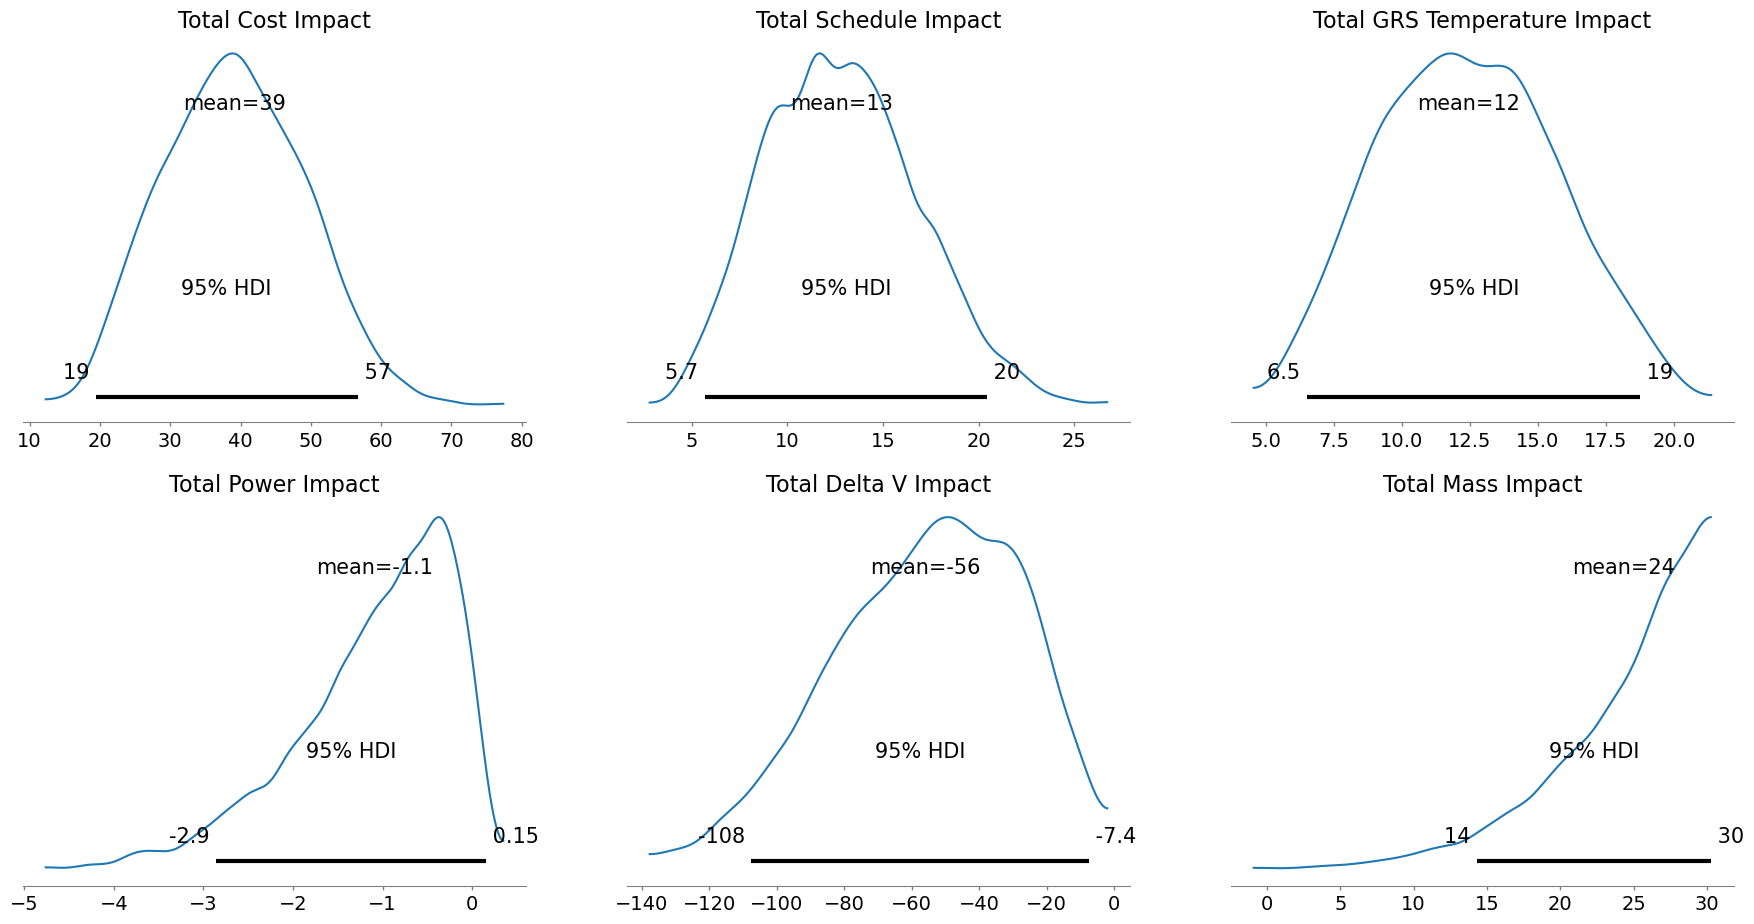

In [65]:
az.plot_posterior(TU5_Results,
                  var_names=['Total'],
                  filter_vars='like',
                  hdi_prob=0.95)

In [66]:
az.summary(TU5_Results,
           var_names=['Total'],
           filter_vars="like",
           round_to=2,
           kind='stats')

,mean,sd,hdi_3%,hdi_97%
Total Cost Impact,39.15,9.93,20.69,56.62
Total Schedule Impact,12.86,3.92,5.70,19.97
Total GRS Temperature Impact,12.45,3.25,6.92,18.82
Total Power Impact,-1.08,0.87,-2.73,0.16
Total Delta V Impact,-56.02,27.36,-103.86,-6.73
Total Mass Impact,24.31,5.05,14.91,30.28


And now the same for Team Update 6:

array([[<AxesSubplot: title={'center': 'Total Cost Impact'}>,
        <AxesSubplot: title={'center': 'Total Schedule Impact'}>,
        <AxesSubplot: title={'center': 'Total Power Impact'}>],
       [<AxesSubplot: title={'center': 'Total Mass Impact'}>,
        <AxesSubplot: title={'center': 'Total Delta V Impact'}>,
        <AxesSubplot: title={'center': 'Total GRS Temperature Impact'}>]],
      dtype=object)

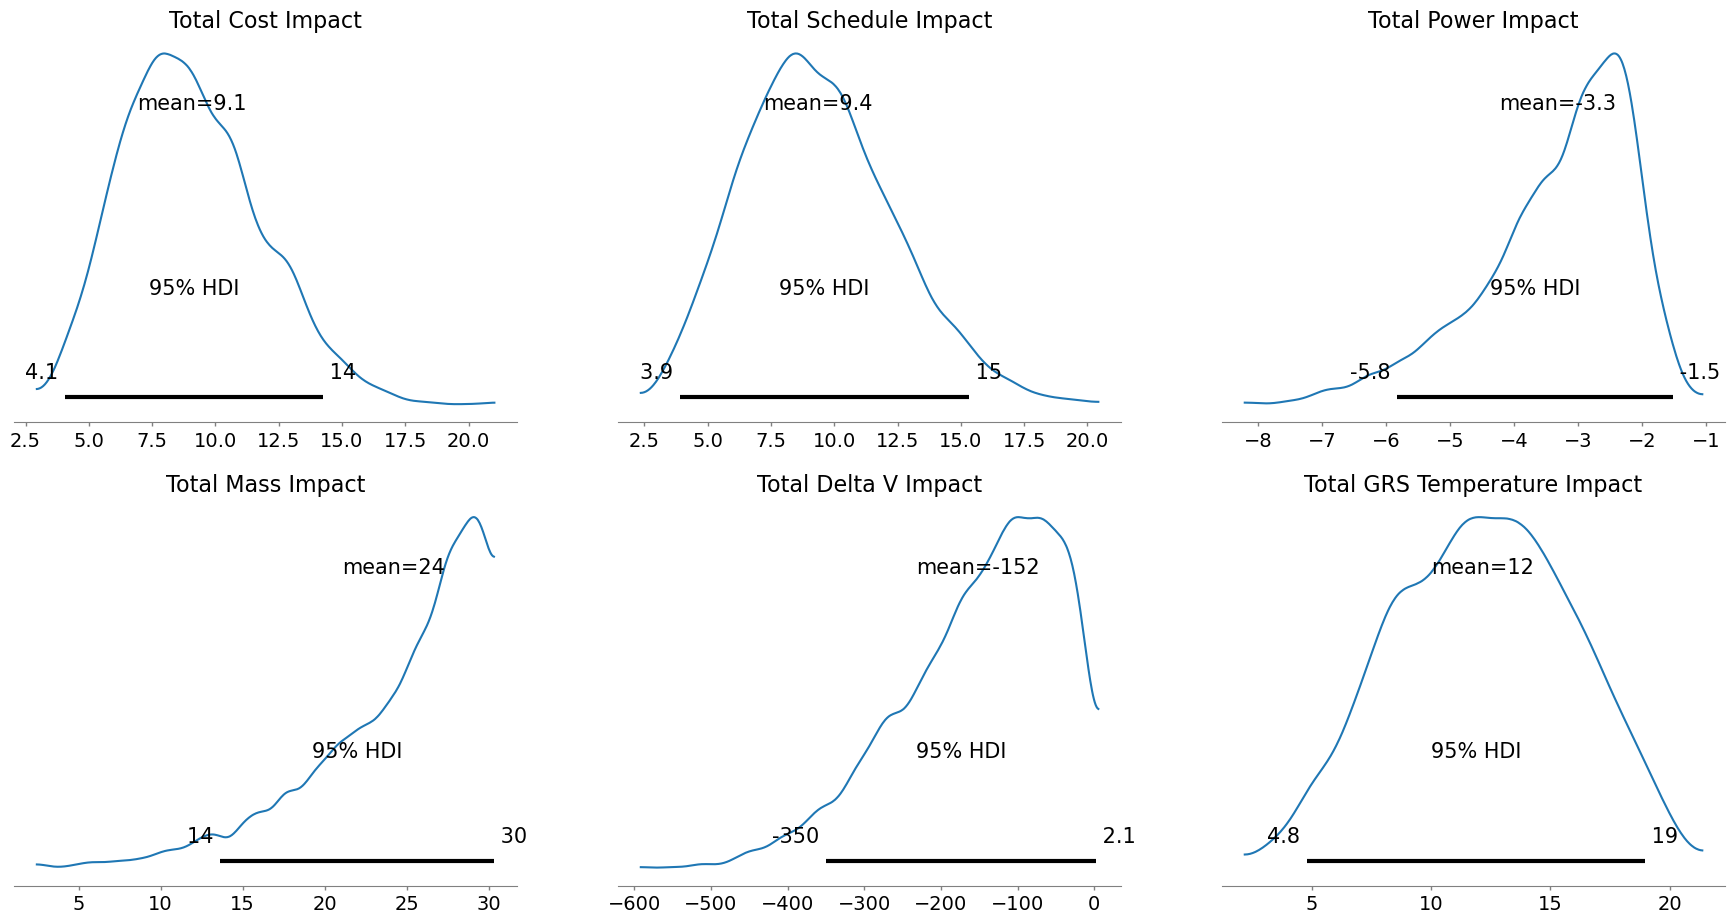

In [67]:
az.plot_posterior(TU6_results,
                  var_names=['Total'],
                  filter_vars='like',
                  hdi_prob=0.95)

In [68]:
az.summary(TU6_results,
           var_names=['Total'],
           filter_vars="like",
           round_to=2,
           kind='stats')

,mean,sd,hdi_3%,hdi_97%
Total Cost Impact,9.06,2.72,4.23,14.07
Total Schedule Impact,9.36,3.00,4.00,14.97
Total Power Impact,-3.32,1.18,-5.69,-1.53
Total Mass Impact,24.20,5.14,14.69,30.32
Total Delta V Impact,-151.77,102.72,-336.17,2.09
Total GRS Temperature Impact,12.16,3.79,5.31,19.15


And now, let's compare the results in terms of utility:

In [48]:
TU6_cost_mean = np.asarray(TU6_results.posterior.mean()['Total Cost Impact'])
TU6_schedule_mean = np.asarray(TU6_results.posterior.mean()['Total Schedule Impact'])

TU6_cost_confidence_bounds = np.asarray(az.hdi(TU6_results, hdi_prob=0.95)['Total Cost Impact'])
TU6_schedule_confidence_bounds = np.asarray(az.hdi(TU6_results, hdi_prob=0.95)['Total Schedule Impact'])

If you've changed your utility functions in some way as part of the design revision for Team Update 6, change out the default alias to the old functions below:

In [49]:
TU6_cost_utility_function = cost_utility_function

In [50]:
TU6_schedule_utility_function = schedule_utility_function

Now, calculate the change in utility from your design revision:

In [51]:
Mean_Cost_Utility_Change = TU6_cost_utility_function(TU6_cost_mean) - TU6_cost_utility_function(cost_mean)

LB_Cost_Utility_Change = TU6_cost_utility_function(TU6_cost_confidence_bounds[0]) - TU6_cost_utility_function(cost_confidence_bounds[0])

UB_Cost_Utility_Change = TU6_cost_utility_function(TU6_cost_confidence_bounds[1]) - TU6_cost_utility_function(cost_confidence_bounds[1])

print(f'Mean Cost Utility Change: {Mean_Cost_Utility_Change:.2f}')

print(f'Lower Bound Cost Utility Change: {LB_Cost_Utility_Change:.2f}')

print(f'Upper Bound Cost Utility Change: {UB_Cost_Utility_Change:.2f}')

Mean Cost Utility Change: 1.66
Lower Bound Cost Utility Change: 0.64
Upper Bound Cost Utility Change: 2.81


In [52]:
Mean_Schedule_Utility_Change = TU6_schedule_utility_function(TU6_schedule_mean) - TU6_schedule_utility_function(schedule_mean)

LB_Schedule_Utility_Change = TU6_schedule_utility_function(TU6_schedule_confidence_bounds[0]) - TU6_schedule_utility_function(schedule_confidence_bounds[0])

UB_Schedule_Utility_Change = TU6_schedule_utility_function(TU6_schedule_confidence_bounds[1]) - TU6_schedule_utility_function(schedule_confidence_bounds[1])

print(f'Mean Cost Utility Change: {Mean_Schedule_Utility_Change:.2f}')

print(f'Lower Bound Cost Utility Change: {LB_Schedule_Utility_Change:.2f}')

print(f'Upper Bound Cost Utility Change: {UB_Schedule_Utility_Change:.2f}')

Mean Cost Utility Change: 1.55
Lower Bound Cost Utility Change: 1.39
Upper Bound Cost Utility Change: 0.32


Now, repeat the process for your technical impacts.

Technical Paramter 1:

In [53]:
U6_Payload_Power_mean = np.asarray(TU6_results.posterior.mean()[f'Total {TU6_Design_System.technical_risk_tables[0].name} Impact'])

U6_Payload_Power_confidence_bounds = np.asarray(az.hdi(TU6_results, hdi_prob=0.95)[f'Total {TU6_Design_System.technical_risk_tables[0].name} Impact'])

In [54]:
U6_Payload_Power_utility_function = U6_Payload_Power_utility_function

In [55]:
Mean_Payload_Power_Utility_Change = U6_Payload_Power_utility_function(U6_Payload_Power_mean) - U6_Payload_Power_utility_function(Payload_Power_mean)

LB_Payload_Power_Utility_Change = U6_Payload_Power_utility_function(U6_Payload_Power_confidence_bounds[0]) - U6_Payload_Power_utility_function(Payload_Power_confidence_bounds[0])

UB_Payload_Power_Utility_Change = U6_Payload_Power_utility_function(U6_Payload_Power_confidence_bounds[1]) - U6_Payload_Power_utility_function(Payload_Power_confidence_bounds[1])

print(f'Mean Cost Utility Change: {Mean_Payload_Power_Utility_Change:.2f}')

print(f'Lower Bound Cost Utility Change: {LB_Payload_Power_Utility_Change:.2f}')

print(f'Upper Bound Cost Utility Change: {UB_Payload_Power_Utility_Change:.2f}')

Mean Cost Utility Change: 0.00
Lower Bound Cost Utility Change: 0.00
Upper Bound Cost Utility Change: 0.00


Technical Parameter 2:

In [56]:
U6_Payload_Mass_mean = np.asarray(TU6_results.posterior.mean()[f'Total {TU6_Design_System.technical_risk_tables[1].name} Impact'])

U6_Payload_Mass_confidence_bounds = np.asarray(az.hdi(TU6_results, hdi_prob=0.95)[f'Total {TU6_Design_System.technical_risk_tables[1].name} Impact'])

In [57]:
U6_Payload_Mass_utility_function = U6_Payload_Mass_utility_function

In [58]:
Mean_Payload_Mass_Utility_Change = U6_Payload_Mass_utility_function(U6_Payload_Mass_mean) - U6_Payload_Mass_utility_function(Payload_Mass_mean)

LB_Payload_Mass_Utility_Change = U6_Payload_Mass_utility_function(U6_Payload_Mass_confidence_bounds[0]) - U6_Payload_Mass_utility_function(Payload_Mass_confidence_bounds[0])

UB_Payload_Mass_Utility_Change = U6_Payload_Mass_utility_function(U6_Payload_Mass_confidence_bounds[1]) - U6_Payload_Mass_utility_function(Payload_Mass_confidence_bounds[1])

print(f'Mean Cost Utility Change: {Mean_Payload_Mass_Utility_Change:.2f}')

print(f'Lower Bound Cost Utility Change: {LB_Payload_Mass_Utility_Change:.2f}')

print(f'Upper Bound Cost Utility Change: {UB_Payload_Mass_Utility_Change:.2f}')

Mean Cost Utility Change: 0.00
Lower Bound Cost Utility Change: 0.00
Upper Bound Cost Utility Change: -0.00


Technical Parameter 3:

In [59]:
U6_Payload_Delta_v_mean = np.asarray(TU6_results.posterior.mean()[f'Total {TU6_Design_System.technical_risk_tables[2].name} Impact'])

U6_Payload_Delta_v_confidence_bounds = np.asarray(az.hdi(TU6_results, hdi_prob=0.95)[f'Total {TU6_Design_System.technical_risk_tables[2].name} Impact'])

In [60]:
U6_Payload_Delta_v_utility_function = U6_Payload_Delta_v_utility_function

In [61]:
Mean_Payload_Delta_v_Utility_Change = U6_Payload_Delta_v_utility_function(U6_Payload_Delta_v_mean) - U6_Payload_Delta_v_utility_function(Payload_Delta_v_mean)

LB_Payload_Delta_v_Utility_Change = U6_Payload_Delta_v_utility_function(U6_Payload_Delta_v_confidence_bounds[0]) - U6_Payload_Delta_v_utility_function(Payload_Delta_v_confidence_bounds[0])

UB_Payload_Delta_v_Utility_Change = U6_Payload_Delta_v_utility_function(U6_Payload_Delta_v_confidence_bounds[1]) - U6_Payload_Delta_v_utility_function(Payload_Delta_v_confidence_bounds[1])

print(f'Mean Cost Utility Change: {Mean_Payload_Delta_v_Utility_Change:.2f}')

print(f'Lower Bound Cost Utility Change: {LB_Payload_Delta_v_Utility_Change:.2f}')

print(f'Upper Bound Cost Utility Change: {UB_Payload_Delta_v_Utility_Change:.2f}')

Mean Cost Utility Change: -0.00
Lower Bound Cost Utility Change: -0.00
Upper Bound Cost Utility Change: 0.00


Technical Parameter 4:

In [62]:
U6_GRS_Temp_mean = np.asarray(TU6_results.posterior.mean()[f'Total {TU6_Design_System.technical_risk_tables[3].name} Impact'])

U6_GRS_Temp_confidence_bounds = np.asarray(az.hdi(TU6_results, hdi_prob=0.95)[f'Total {TU6_Design_System.technical_risk_tables[3].name} Impact'])

In [63]:
U6_GRS_Temp_utility_function = U6_GRS_Temp_utility_function

In [64]:
Mean_GRS_Temp_Utility_Change = U6_GRS_Temp_utility_function(U6_GRS_Temp_mean) - U6_GRS_Temp_utility_function(GRS_Temp_mean)

LB_GRS_Temp_Utility_Change = U6_GRS_Temp_utility_function(U6_GRS_Temp_confidence_bounds[0]) - U6_GRS_Temp_utility_function(GRS_Temp_confidence_bounds[0])

UB_GRS_Temp_Utility_Change = U6_GRS_Temp_utility_function(U6_GRS_Temp_confidence_bounds[1]) - U6_GRS_Temp_utility_function(GRS_Temp_confidence_bounds[1])

print(f'Mean Cost Utility Change: {Mean_GRS_Temp_Utility_Change:.2f}')

print(f'Lower Bound Cost Utility Change: {LB_GRS_Temp_Utility_Change:.2f}')

print(f'Upper Bound Cost Utility Change: {UB_GRS_Temp_Utility_Change:.2f}')

Mean Cost Utility Change: 0.01
Lower Bound Cost Utility Change: 0.04
Upper Bound Cost Utility Change: -0.01


# Assignment Submission:

Once your results are in place for all of the above elements, print the notebook to a PDF and submit it to Canvas.